In [1]:
##############################################
##### PARTIE 1 : IMPORTATION DES DONNEES #####
##############################################

In [ ]:
# Dans cette partie, on importe des données relatives aux risques (pollutions industrielles, inondations, qualité de l'air, sites pollués) et le tableau descriptif
# des communes tel que mis à disposition par l'INSEE.
# L'objectif est de faire la jointure est ces deux types de sources.

In [3]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.8 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [contextily]9 [geopy]io]


In [1]:
# Importation des modules utiles pour cette partie

import requests
import zipfile
import openpyxl

import pandas as pd
import geopandas as gpd

In [2]:
#### On importe le fichier répertoriant les installations industrielles rejetant des polluants, disponible sur Géorisques

# On télécharge le fichier avec la localisation des installations industrielles rejetant des polluants, directement depuis le site Géorisques
url_industries_polluantes = "https://files.georisques.fr/irep/2023.zip"
response_industries_polluantes = requests.get(url_industries_polluantes)

# On enregistre le dossier localement
with open("Industries_polluantes.xlsx", "wb") as f:
    f.write(response_industries_polluantes.content)

# On importe le fichier répertoriant les établissements polluants (qui est une liste des établissements)
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/etablissements.csv") as f:
        industries_polluantes = pd.read_csv(f, sep=None, engine='python')

# On renomme la colonne insee dès maintenant (pour harmoniser ensuite)
industries_polluantes = industries_polluantes.rename(columns={"code_insee" : "insee"})
industries_polluantes.head()

# On importe le fichier des rejets (pour chaque établissement listé dans industries_polluantes)
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/rejets.csv") as f:
        rejets = pd.read_csv(f, sep=None, engine='python')
rejets = rejets.rename(columns = {"code_insee" : "insee"})
rejets.head()

# On fusionne les deux tables
etablissements_rejets = pd.merge(industries_polluantes, rejets, on=["identifiant", "nom_etablissement", "code_postal", "insee",
"commune", "code_departement", "departement", "code_region", "region"], how="inner")

# On obtient les variables d'intérêt suivantes :
# nom de l'établissement (pour le versant établissements);
# année des rejets, total des rejets raccordés au réseau, total des rejets isolés (pour le versant rejets)
etablissements_rejets.columns

# On regroupe par la commune et on enregistre les pollutions (total des rejets ET nombre d'établissements)
etablissements_rejets_agr = etablissements_rejets.groupby("insee").agg(
    rejets_isoles=("rejet_isole_m3_par_an", "sum"),
    nb_etablissements_isoles=("rejet_isole_m3_par_an", "count"),
    rejets_raccordes=("rejet_raccorde_m3_par_an", "sum"),
    nb_etablissements_raccordes=("rejet_raccorde_m3_par_an", "count")).reset_index()

# On fait, pour chaque commune, la somme des rejets raccordés et isolés pour les deux colonnes concernées
etablissements_rejets_agr["rejets_tot"] = etablissements_rejets_agr["rejets_isoles"] + etablissements_rejets_agr["rejets_raccordes"]
etablissements_rejets_agr["nb_etablissements_tot"] = etablissements_rejets_agr["nb_etablissements_isoles"] + etablissements_rejets_agr["nb_etablissements_raccordes"]

In [3]:
#### On importe le fichier avec les shapefiles des communes

# Téléchargement du fichier avec les shapefiles des communes, directement depuis Datagouv
url_communes = "https://www.data.gouv.fr/api/1/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
zip_communes = "shapefiles.zip"

# Enregistrement du fichier localement
response_communes = requests.get(url_communes)
with open(zip_communes, "wb") as f:
    f.write(response_communes.content)

# Importation avec GeoPandas
communes = gpd.read_file(f"zip://{zip_communes}!communes-20220101.shp")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9..."


In [4]:
# On essaye de créer dupliquer les colonnes Paris, Lyon et Marseille pour voir

communes_ext = communes.copy()

## Pour Paris

# On enregistre la ligne de Paris
communes_paris = communes_ext[communes_ext["insee"] == "75056"]

# On la copie 20 fois
communes_paris_20 = communes_paris.loc[communes_paris.index.repeat(20)].copy()

# On change uniquement la colonne insee (on changera les autres plus tard selon les besoins)
communes_paris_20["insee"] = [f"751{str(i).zfill(2)}" for i in range(1, 21)]    #f" permet d'insérer une variable dans une chaîne, str(i) convertit les chiffres et zfill ajoute des zéros à gauche pour le code insee

# On ajoute nos lignes au df original
i = communes_paris.index[0]         # on récupère la position de la ligne de Paris
communes_ext = pd.concat(                       # on assemble deux df aux colonnes identiques via pd.concat
    [communes_ext.iloc[:i+1], communes_paris_20, communes_ext.iloc[i+1:]],       # toutes nos lignes jusqu'à Paris - puis Paris - puis tout le reste 
    ignore_index=True
)

## Idem pour Lyon
communes_lyon = communes_ext[communes_ext["insee"] == "69123"]
communes_lyon_20 = communes_lyon.loc[communes_lyon.index.repeat(9)].copy()
communes_lyon_20["insee"] = [f"6938{str(i)}" for i in range(1, 10)]

j = communes_lyon.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:j+1], communes_lyon_20, communes_ext.iloc[j+1:]],
    ignore_index=True
)

## Et pour Marseille
communes_marseille = communes_ext[communes_ext["insee"] == "13055"]
communes_marseille_20 = communes_marseille.loc[communes_marseille.index.repeat(16)].copy()
communes_marseille_20["insee"] = [f"132{str(i).zfill(2)}" for i in range(1, 17)]

k = communes_marseille.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:k+1], communes_marseille_20, communes_ext.iloc[k+1:]],
    ignore_index=True
)

In [5]:
### On fait une première fusion entre les communes et les pollutions industrielles

# On fait la jointure (en ne conservant que les communes qui sont dans les deux df, ie celles qui ont des rejets identifiés)
communes_rejets = pd.merge(communes_ext, etablissements_rejets_agr, on="insee", how = "inner")

# Conversion du fichier au format GeoPandas
communes_rejets = gpd.GeoDataFrame(communes_rejets, geometry='geometry')

# On crée un df avec les communes et une variable polluée ou non (binaire)
communes_statut = communes_ext.copy()
communes_statut["Polluee"] = communes_statut["insee"].isin(communes_rejets["insee"])

# On regarde combien on en a (2 375 polluées parmi 35 000 : environ 6-7%)
print(communes_statut["Polluee"].sum(), communes_ext.shape)

2393 (35000, 5)


In [6]:
# Avant de fusionner etablissements_rejets et communes_statut, on vérifie qu'il n'y a pas d'incohérence
print(
    (set(etablissements_rejets["insee"].astype(str)) - set(communes_statut["insee"].astype(str))),
    (set(communes_statut["insee"].astype(str)) - set(etablissements_rejets["insee"].astype(str)))
    )

# On supprime les codes en trop
codes_pollution = set(etablissements_rejets["insee"].astype(str))
codes_communes  = set(communes_statut["insee"].astype(str))
codes_non_trouves = codes_pollution - codes_communes
codes_arrondissements = {c for c in codes_non_trouves if c.startswith(("75", "13", "69"))}
etablissements_rejets = etablissements_rejets[
    ~etablissements_rejets["insee"].astype(str).isin(codes_non_trouves - codes_arrondissements)
]

{'61356', '01154', '49276', '85217', '73002', '27676', '85212', '16274', '50163', '74268', '33267', '50354', '49204', '79264', '49039', '49274'} {'28261', '67298', '57587', '12025', '71526', '37040', '01346', '77378', '84099', '33085', '85259', '30185', '56215', '29123', '80199', '39447', '05092', '32145', '38150', '88133', '45251', '02459', '88233', '39083', '88349', '36038', '54564', '33545', '47164', '87168', '65405', '02170', '27258', '68054', '23029', '14127', '21243', '76250', '57515', '69086', '28216', '28212', '64236', '59595', '45193', '73308', '14759', '73001', '11285', '89038', '51151', '36082', '22237', '14569', '87169', '78380', '11236', '62811', '54489', '43195', '28167', '62061', '31574', '65274', '76523', '62609', '62553', '32186', '17098', '49174', '34320', '14407', '65105', '02612', '58067', '35151', '62124', '70302', '69104', '68119', '77261', '17391', '95351', '21068', '51192', '55095', '88122', '60400', '76392', '33255', '21263', '22333', '70481', '57375', '07023',

In [7]:
# On fusionne pour Paris, Lyon et Marseille (dans une colonne à part au cas où)
etablissements_rejets["insee_agr"] = etablissements_rejets["insee"]
etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["13203", "13205", "13208", "13209", "13210", "13211", "13214", "13215", "13216"],
"13055").astype(str)
etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["69383", "69384", "69387", "69388", "69389"],"69123").astype(str)
etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["75101", "75109", "75111", "75112", "75115"],"75056").astype(str)

In [8]:
# On fusionne etablissements_rejets_agr et communes_statut (ce qui réduit communes_statut aux communes polluées)
communes_statut = pd.merge(communes_statut, etablissements_rejets_agr, on = "insee", how = "left")

In [ ]:
# On ne conserve que les villes qui ont un rejet isolé positif
#communes_statut = communes_statut[communes_statut["rejets_tot"] > 0]

In [35]:
#### On importe le dossier complet de l'INSEE pour apparier avec des données "sociales"

# On télécharge le dossier qui contient notre csv
url_complet = "https://www.insee.fr/fr/statistiques/fichier/5359146/dossier_complet.zip"
zip_path = "dossier_complet.zip" 

# On enregistre le fichier localement
response = requests.get(url_complet)
with open(zip_path, "wb") as f:
    f.write(response.content)

# On importe notre fichier avec Pandas (et on l'appelle complet_insee)
csv_complet_insee = "dossier_complet.csv" 
with zipfile.ZipFile(zip_path) as z:
    with z.open(csv_complet_insee) as f:
        complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')

/tmp/ipykernel_34431/1042689086.py:16: DtypeWarning: Columns (0,1701,1702) have mixed types. Specify dtype option on import or set low_memory=False.
  complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')


In [45]:
# On renomme la colonne CODGEO en insee (comme tous les autres df)
complet_insee = complet_insee.rename(columns={"CODGEO" : "insee"})

# Puis on la convertit en chaine
complet_insee["insee"] = complet_insee["insee"].astype(str).str.zfill(5)

In [46]:
# On duplique Paris, Lyon et Marseille dans complet_insee également

complet_ext = complet_insee.copy()

complet_paris = complet_ext[complet_ext["insee"] == "75056"].copy()
complet_paris_20 = complet_paris.loc[complet_paris.index.repeat(20)].copy()
complet_paris_20["insee"] = [f"751{str(i).zfill(2)}" for i in range(1, 21)]
i = complet_paris.index[0]
complet_ext = pd.concat(
    [complet_ext.iloc[:i+1], complet_paris_20, complet_ext.iloc[i+1:]],
    ignore_index=True
)

## Idem pour Lyon
complet_lyon = complet_ext[complet_ext["insee"] == "69123"]
complet_lyon_20 = complet_lyon.loc[complet_lyon.index.repeat(9)].copy()
complet_lyon_20["insee"] = [f"6938{str(i)}" for i in range(1, 10)]
j = complet_lyon.index[0]
complet_ext = pd.concat(
    [complet_ext.iloc[:j+1], complet_lyon_20, complet_ext.iloc[j+1:]],
    ignore_index=True
)

## Et pour Marseille
complet_marseille = complet_ext[complet_ext["insee"] == "13055"]
complet_marseille_20 = complet_marseille.loc[complet_marseille.index.repeat(16)].copy()
complet_marseille_20["insee"] = [f"132{str(i).zfill(2)}" for i in range(1, 17)]
k = complet_marseille.index[0]
complet_ext = pd.concat(
    [complet_ext.iloc[:k+1], complet_marseille_20, complet_ext.iloc[k+1:]],
    ignore_index=True
)

In [47]:
#### On fait à nouveau la jointure avec notre df précédent

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_statut['insee'] = communes_statut['insee'].astype(str).str.zfill(5)    # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
complet_insee['insee'] = complet_insee['insee'].astype(str).str.zfill(5)

# On fusionne
communes_complet = pd.merge(communes_statut, complet_insee, on="insee") # on obtient un tableau à 1987 colonnes (et 34 976 lignes)
communes_complet.shape

(34976, 1987)

In [ ]:
#### On importe le fichier répertoriant les catastrophes naturelles de type inondations reconnues pour chaque commune

# Téléchargement du fichier avec le nombre de catastrophes reconnues pour chaque commune, directement depuis le site Géorisques
#url_inondations = "https://files.georisques.fr/onrn/2025/ONRN_Reco_INON_8224.xlsx"
#response_inondations = requests.get(url_inondations)

# Enregistrement du fichier localement
#with open("ONRN_Reco_INON_8224.xlsx", "wb") as f:
#    f.write(response_inondations.content)

# Importation et ouverture avec Pandas
#inondations = pd.read_excel("ONRN_Reco_INON_8224.xlsx", sheet_name="Nb reco. Cat Nat")

# On renomme les colonnes
#inondations.columns = ['insee', 'Commune', 'Occurrences_inondations'] 

In [ ]:
#### Je mets en pause ces lignes car les inondations ne sont pas disponibles par arrondissement

# On remarque que communes_complet prend en compte des communes en outre-mer (et pas inondations)
#set(communes_complet["insee"].astype(str)) - set(inondations["insee"].astype(str))

# On les supprime
#codes_complet = set(communes_complet["insee"].astype(str))
#codes_inondations  = set(inondations["insee"].astype(str))
#codes_a_supprimer = codes_complet - codes_inondations
#communes_complet = communes_complet[
#    ~communes_complet["insee"].astype(str).isin(codes_a_supprimer)
#]

In [ ]:
# On remarque, dans l'autre sens, que inondations prend en compte des communes qui n'existent plus (et qui ne sont pas dans communes_complet)
#set(inondations["insee"].astype(str)) - set(communes_complet["insee"].astype(str))

# On les supprime également, avant de faire la jointure
#codes_a_supprimer_2 = codes_inondations - codes_complet
#inondations = inondations[
#    ~inondations["insee"].astype(str).isin(codes_a_supprimer_2)
#]

In [ ]:
### Préparation du dataframe de travail

# On s'assure qu'on a bien le même nombre de lignes
#print(inondations.shape, communes_complet.shape)

# On renomme la colonne "nom" en "Commune" dans communes_complet (pour faire le merge sur insee ET sur Commune pour être sûr et ne pas doubler la colonne)
#communes_complet = communes_complet.rename(columns={"nom" : "Commune"})

# On fait la jointure
#communes_complet = pd.merge(communes_complet, inondations, on=["insee", "Commune"])

(34802, 3) (34802, 1987)


In [ ]:
# On remplace "Pas de reconnaissance" par 0 (on transforme la ligne en numérique : les erreurs (ie les caractères) sont alors convertis en 0)
#communes_complet["Occurrences_inondations"] = pd.to_numeric(communes_complet["Occurrences_inondations"], errors="coerce").fillna(0)

In [ ]:
##############################################
####### PARTIE 2 : RECODAGE POUR L'IDF #######
##############################################

In [174]:
### On se concentre sur l'idf

# On crée un df communes seulement avec l'idf
communes_complet["departement"] = communes_complet["insee"].astype(str).str.slice(0,2)
communes_idf = communes_complet.copy()
communes_idf = communes_idf[communes_idf["departement"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

In [175]:
## On importe la pollution de l'air

# On ouvre le df avec la pollution de l'air
url_pollution_air = "https://www.data.gouv.fr/api/1/datasets/r/da7a4869-b584-48ad-8a81-784a02eb297a"
pollution_air = pd.read_csv(url_pollution_air) 
pollution_air.shape

# On se restreint aux mesures de 2018 (les plus récentes)
pollution_air_2018 = pollution_air[pollution_air['date'] == '01/04/2018'].copy()

# S'assurer que la colonne est bien au format string
pollution_air_2018['ninsee'] = pollution_air_2018['ninsee'].astype(str)

# Garder seulement les codes INSEE de 5 chiffres ou plus
pollution_air_2018 = pollution_air_2018[pollution_air_2018['ninsee'].str.len() >= 5]

# On renomme la variable CODGEO en "insee" pour que ce soit homogène
pollution_air_2018 = pollution_air_2018.rename(columns={"ninsee":"insee"})

In [176]:
#### Avant de faire la jointure, on regarde si des lignes diffèrent entre pollution_air_2018 et communes_idf

# On regarde la taille des deux df
print(communes_idf.shape, pollution_air_2018.shape) # il y a 13 lignes de plus dans pollution_air_2018

# On regarde quelles lignes manquent

# Dans ce sens, ce sont des communes qui ont disparues depuis 2018
set(pollution_air_2018["insee"].astype(str)) - set(communes_idf["insee"].astype(str))

# Dans l'autre sens, il n'y a que Paris (qui n'existe pas dans pollution_air_2018 car ce sont des arrondissements) - on accepte de la perdre !

(1287, 1988) (1300, 5)


{'77028',
 '77149',
 '77166',
 '77170',
 '77299',
 '77399',
 '77491',
 '78251',
 '78503',
 '78524',
 '91182',
 '91222',
 '95259',
 '95282'}

In [177]:
#### On fait la jointure avec notre df sur la pollution de l'air (qui ne concerne que l'idf)

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_idf['insee'] = communes_idf['insee'].astype(str).str.zfill(5)  # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
pollution_air_2018['insee'] = pollution_air_2018['insee'].astype(str).str.zfill(5)

# On fusionne
communes_idf = pd.merge(communes_idf, pollution_air_2018, on="insee") 
communes_idf.shape

(1286, 1992)

In [178]:
## Nettoyage

# On nettoie le revenu médian en supprimant les (15) lignes non renseignées
communes_idf[communes_idf['MED21'] == 's']
communes_idf = communes_idf[communes_idf['MED21'] != 's']

In [179]:
### On importe les bonnes géométries pour les arrondissements parisiens

# Téléchargement du fichier avec les shapefiles des communes, directement depuis le site de la ville de Paris
url_arrondissements = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
csv_arrondissements = "arrondissements.csv"

# Enregistrement du fichier localement
response_arrondissements = requests.get(url_arrondissements)
with open(csv_arrondissements, "wb") as f:
    f.write(response_arrondissements.content)

# Importation avec GeoPandas
arrondissements = gpd.read_file(csv_arrondissements)

# On ne garde que les colonnes qui nous intéressent, on les renomme et on convertit la surface (de m2 à ha)
arrondissements = arrondissements.iloc[:, [2, 6, 9]]
arrondissements.columns = ["insee", "surf_ha", "geometry"]
arrondissements["surf_ha"] = arrondissements["surf_ha"].astype(float) / 10_000

In [180]:
### On fusionne nos arrondissements avec notre fichier des communes (pour mettre à jour la géométrie - le reste est déjà correct)

# On convertit la colonne geometry en Shapely (elle était en JSON nativement)
import json
from shapely.geometry import shape
arrondissements["geometry"] = arrondissements["geometry"].apply(lambda x: shape(json.loads(x)))
arrondissements["geometry"] = arrondissements["geometry"].apply(shape)

# On ajoute nos arrondissements
for col in ["surf_ha", "geometry"]:
    # On crée un dictionnaire qui, à chaque code insee, assigne la nouvelle valeur de la colonne
    update_dict = dict(zip(arrondissements["insee"], arrondissements[col]))
    
    # On remplace dans communes_idf_short
    communes_idf[col] = communes_idf["insee"].map(update_dict).combine_first(communes_idf[col])

# On s'assure qu'on a toujours un gdf
communes_idf = gpd.GeoDataFrame(
    communes_idf,
    geometry='geometry', 
    crs="EPSG:2154"
)

In [181]:
#### On ajoute la variable du centroid au df (pour faire des calculs simples éventuellement)
communes_idf['centroid'] = communes_idf.geometry.centroid 
communes_idf['x'] = communes_idf.centroid.x # coordonnées est-ouest (longitude)
communes_idf['y'] = communes_idf.centroid.y # nord-sud (latitude)

In [182]:
#### On réduit, à titre provisoire, notre df à quelques variables d'intérêt

# On sélectionne les variables
communes_idf_short = communes_idf.copy()
communes_idf_short = communes_idf_short[["insee", "nom", "departement", "surf_ha", "geometry", "centroid", "x", "y",
'TP6021', 'MED21', 'SNEMM_23', 'P22_POP',
"Polluee", "rejets_isoles", "nb_etablissements_isoles", "rejets_raccordes", "nb_etablissements_raccordes", "rejets_tot", "nb_etablissements_tot",
"no2", "o3", "pm10"]]

In [ ]:
####################################################
####### PARTIE 3 : STATISTIQUES DESCRIPTIVES #######
####################################################

In [57]:
#### Quelques corrélations

# Avec le revenu médian
communes_idf_short["pm10"].corr(communes_idf_short["MED21"])
communes_idf_short["o3"].corr(communes_idf_short["MED21"])
communes_idf_short["no2"].corr(communes_idf_short["MED21"])

# Avec la taille de la commune
communes_idf_short["pm10"].corr(communes_idf_short["P22_POP"])
communes_idf_short["o3"].corr(communes_idf_short["P22_POP"])
communes_idf_short["no2"].corr(communes_idf_short["P22_POP"])


np.float64(0.5181867881860566)

In [ ]:
##############################################
########## PARTIE 4 : VISUALISATIONS #########
##############################################

In [59]:
import matplotlib.pyplot as plt
import contextily as ctx

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

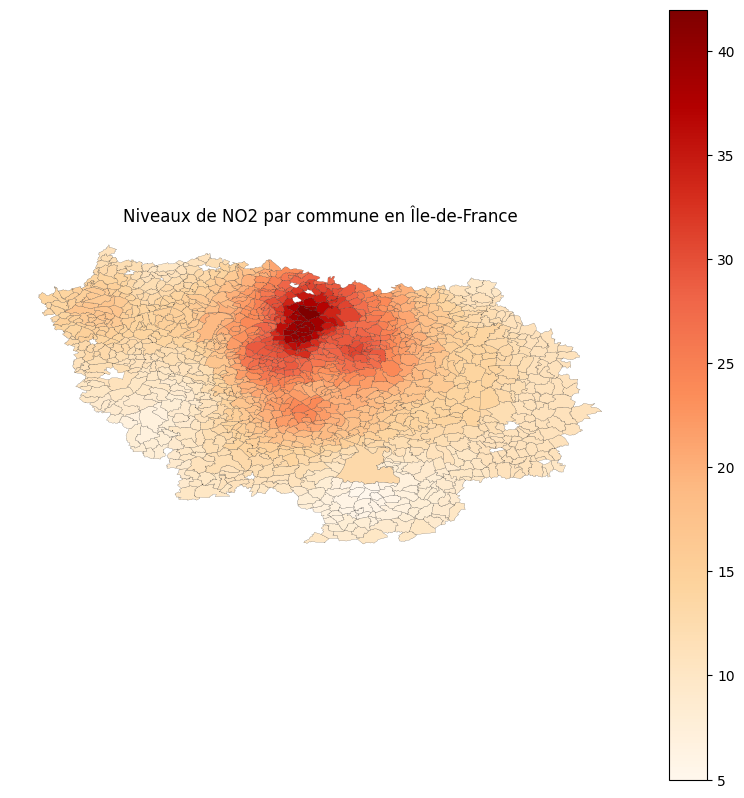

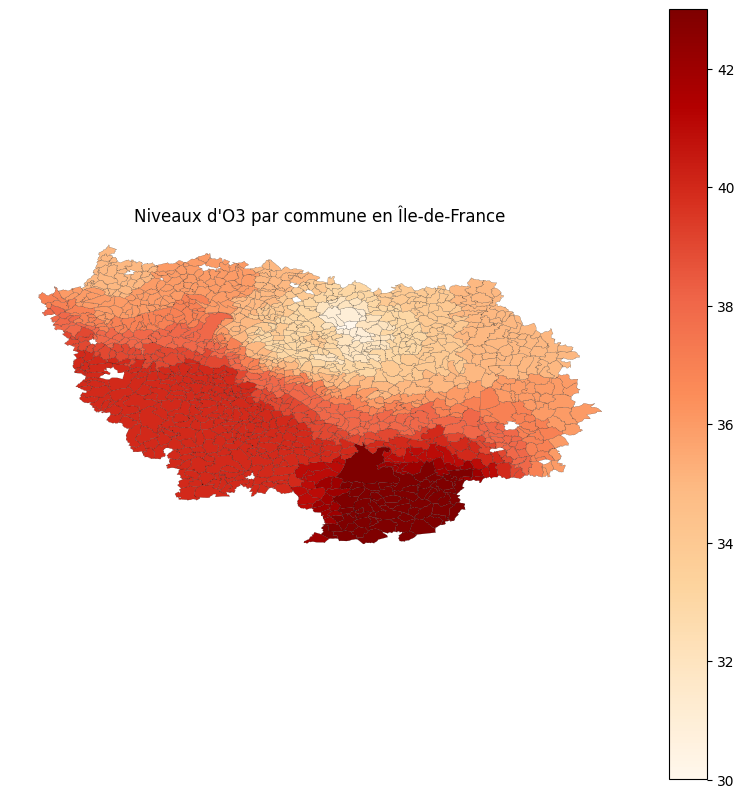

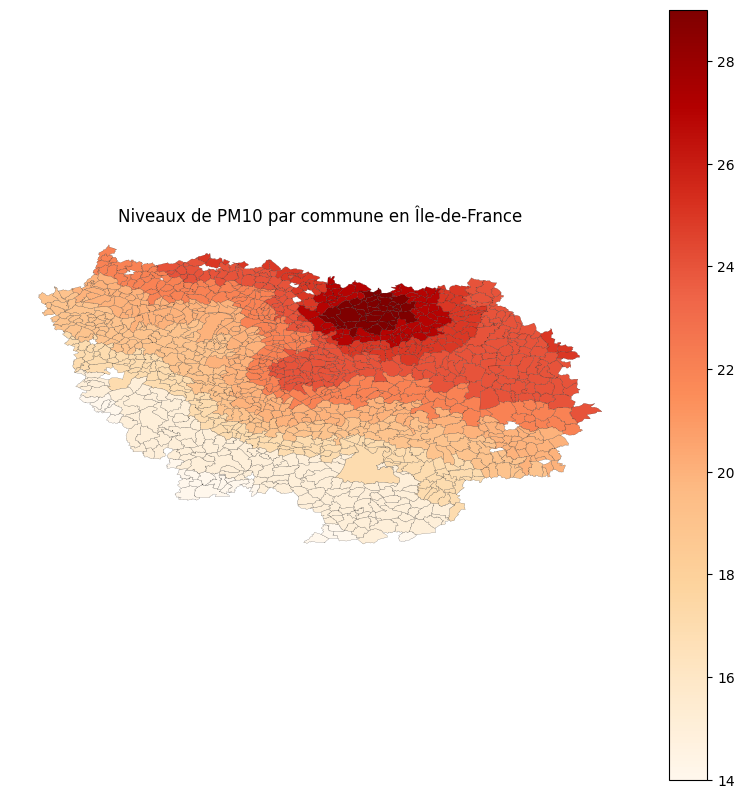

In [183]:
# NO2
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="no2",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux de NO2 par commune en Île-de-France")
ax.axis("off")

# 03
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="o3",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux d'O3 par commune en Île-de-France")
ax.axis("off")


fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="pm10",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Niveaux de PM10 par commune en Île-de-France")
ax.axis("off")

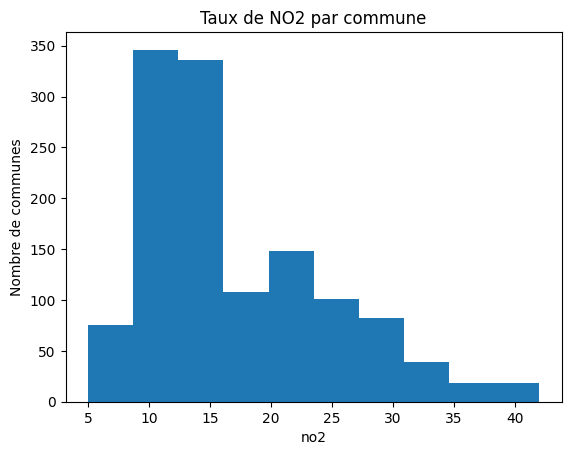

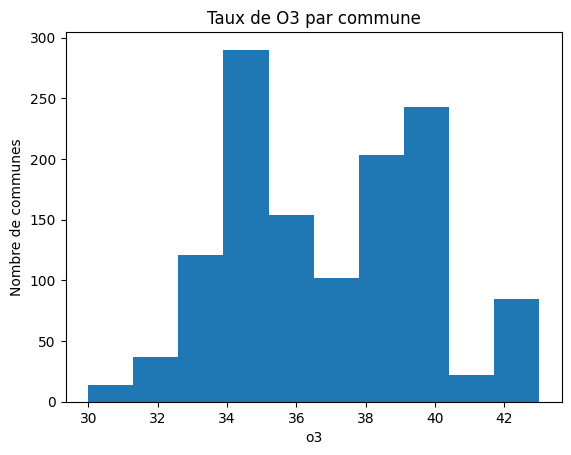

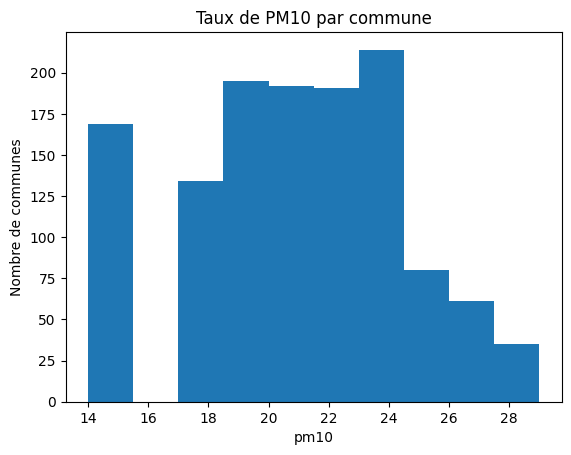

In [184]:
# NO2
plt.hist(communes_idf["no2"])
plt.xlabel("no2")
plt.ylabel("Nombre de communes")
plt.title("Taux de NO2 par commune")
plt.show()

# O3
plt.hist(communes_idf["o3"])
plt.xlabel("o3")
plt.ylabel("Nombre de communes")
plt.title("Taux de O3 par commune")
plt.show()

# PM10
plt.hist(communes_idf["pm10"])
plt.xlabel("pm10")
plt.ylabel("Nombre de communes")
plt.title("Taux de PM10 par commune")
plt.show()

In [ ]:
##############################################
######### PARTIE 5 : MODELISATION ############
##############################################